## Example NLP pipeline for sentiment analysis
### !! This pipeline is specific for Turkish text, it is just supposed to give an idea on what options there are for the different steps

In [1]:
import json
import tqdm
import os
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
#from TurkishStemmer import TurkishStemmer

In [2]:
data = {}
for file in os.listdir("../analytics/"):
    if file.endswith(".json") and "db" in file:
        with open("../analytics/" + file, "r") as fp:
            data.update({file.split(".")[:-1][-1][-1]: json.load(fp)["_default"]})

In [3]:
data.keys()

dict_keys(['3', '1', '0', '4', '2'])

In [4]:
reviews = []

for i in data.keys():
    for product in data[i].values():
        for review in product["reviews"]:
            if review not in reviews:
                reviews.append(review)

In [5]:
len(reviews)

13443

In [2]:
with open("/home/maren/ali_turkish_nlp/data/hepsiburada_reviews.json", "r") as fp:
    reviews = json.load(fp)

## Data exploration
- distribution of word lengths
- most common words / morphemes

In [2]:
import numpy as np
import matplotlib.pyplot as plt

In [43]:
word_lengths = []
word_lengths_raw = []
words_already_seen = []
for review in tqdm.tqdm(reviews):
    for word in review["review_text"].split():
        word_lengths.append(len(word))
        if word not in words_already_seen:
            word_lengths_raw.append(len(word))
            words_already_seen.append(word)
word_lengths = np.array(word_lengths).flatten()

100%|██████████| 12307/12307 [01:18<00:00, 157.65it/s]


In [44]:
len(word_lengths)

287172

In [45]:
len(word_lengths_raw)

46244

In [48]:
max(word_lengths_raw)

37

In [49]:
min(word_lengths_raw)

1

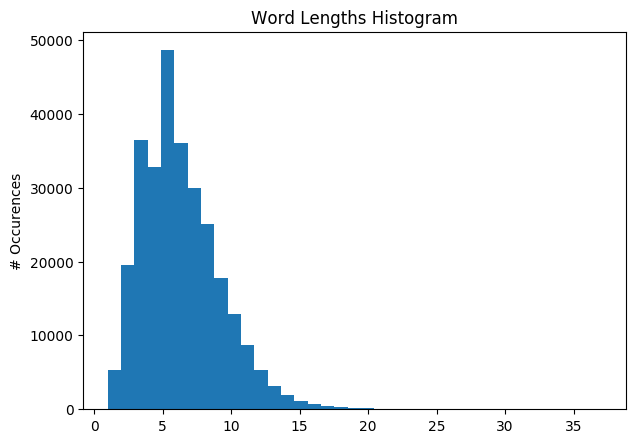

In [50]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(word_lengths, bins=37)
plt.gca().set(title='Word Lengths Histogram', ylabel='# Occurences');

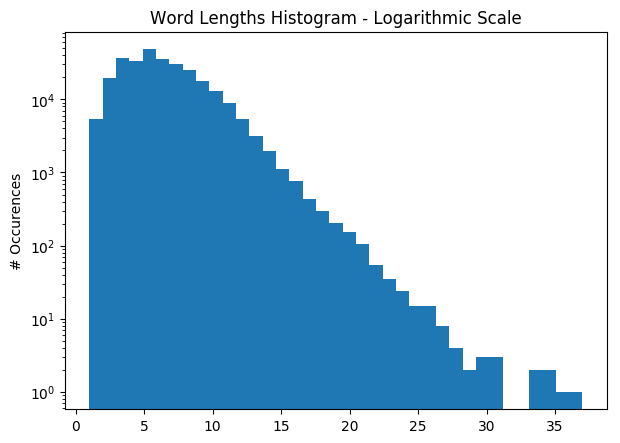

In [290]:
plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})

# Plot Histogram on x
plt.hist(word_lengths, bins=37, log=True)
plt.gca().set(title='Word Lengths Histogram - Logarithmic Scale', ylabel='# Occurences');

### Raw count (without number of occurences)

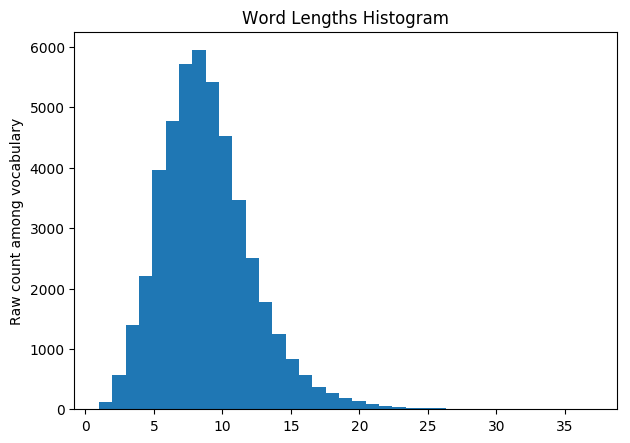

In [54]:
plt.hist(word_lengths_raw, bins=37)
plt.gca().set(title='Word Lengths Histogram', ylabel='Raw count among vocabulary');

- Most common words

In [15]:
corpus = [review["review_text"] for review in reviews]
word_vectorizer = CountVectorizer()
vectorized_corpus = word_vectorizer.fit_transform(corpus)

In [16]:
all_counts = np.sum(np.asarray(vectorized_corpus.todense()), axis=0)

In [229]:
sorted_word_inds = np.argsort(all_counts)[::-1]
sorted_word_counts = np.sort(all_counts)[::-1]

In [230]:
sorted_words = np.array(word_vectorizer.get_feature_names())[sorted_word_inds]

In [231]:
for word, count in list(zip(sorted_words, sorted_word_counts))[:20]:
    print("{0}: {1}".format(word, count))

çok: 6665
bir: 6123
ve: 5788
ürün: 4482
iyi: 3656
güzel: 3131
bu: 2879
için: 2543
ama: 2129
gayet: 2037
daha: 1934
hızlı: 1875
ederim: 1861
tavsiye: 1799
kargo: 1650
da: 1568
teşekkürler: 1517
de: 1471
geldi: 1416
ile: 1399


# NLP pipeline

## 0. pre-processing
- highly language dependent
- options: stemming, lemmatization, lowercasing, removing digits, removing punctuation, removing stop words, emoticon replacement
    - so far, I found the most efficient pipeline to be: removing digits, removing punctuation, lowercasing, and removing stop words. 

In [ ]:
import json
with open("/home/izel/PycharmProjects/ali_turkish_nlp/data/all_reviews.json", "r") as fp:
    reviews = json.load(fp)
    print(len(reviews))

In [ ]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import sys
import grpc
import copy
import zemberek_grpc.normalization_pb2 as z_normalization
import zemberek_grpc.normalization_pb2_grpc as z_normalization_g
import zemberek_grpc.morphology_pb2 as z_morphology
import zemberek_grpc.morphology_pb2_grpc as z_morphology_g

nltk.download("punkt")
channel = grpc.insecure_channel('localhost:6789') #default value is 6789 
normalization_stub = z_normalization_g.NormalizationServiceStub(channel)
morphology_stub = z_morphology_g.MorphologyServiceStub(channel)


In [ ]:
def normalize(i):
    response = normalization_stub.Normalize(z_normalization.NormalizationRequest(input=i))
    return response

def analyze(i):
    response = morphology_stub.AnalyzeSentence(z_morphology.SentenceAnalysisRequest(input=i))
    return response

def get_lemma(texty):
 analysis_result = analyze(texty)
 lemmatized_sentence=""
 for a in analysis_result.results:
  best = a.best
  if("Neg" in best.analysis ):
   lemma=best.lemmas[0]+"_"
  else:
   lemma=best.lemmas[0]
    #print("Word = " + a.token + ", Lemma = " + lemma + ", POS = [" + best.pos + "], Full Analysis = {" + best.analysis + "}")
  lemmatized_sentence=lemmatized_sentence+" "+lemma
 return lemmatized_sentence  

#get_lemma("tarihinde telefon elime ulaştı. Cihazı siparişi verdikten sonra yorumlar beni tedirgin etmişti. ama bu telefonun özelliklerine iyi olduğunu biliyordum. Yapılan yorumlara göre ya ben telefondan anlamıyorum, yada onlar çok iyi anlıyor. kargo paketinin içinde ayrıca  32 gb hafıza kartı çıktı. cihaz yüz tanıma ve parmak izi özelliğini inanılmaz hızlı algılyor. 32 gb dahili hafızası, 3 gb ram , 8 çekirdek, 1080*2340 ekran çözünürlüğü, 409 ppi ve 5000 mah bataryası, hızlı şarj özelliği olmasıyla göz dolduran bu fiyata bu özellikler yok yok dedirten bir telefon olmuş.   full hd+ ekranı beklenenin üzerinde bir görüntü veriyor. pil yüzdesi 15 iken  şarjın dolması hızlı şarjda iken tam 2 saat 20 dk da şarj oluyor. internet açıkken ortalama en az 3 gün gidiyor. telefonu daha 3 kez şarj ettimki  batarya düzene girdikçe şarjı daha çok gideblir..arka Kamera çift olması geniş açılı çekmesi ve ön kameranın flaşının gömülü olması artı özellik. sonsuz ekran. bu özelliklere ve samung markasına bakılarak M20 telefon alınacaklar arasındadır")

In [ ]:
def get_emoticon_token(word_token):
    a=[":-)", ":)", "^^", "^.^","🙏","👏","😊","💐","👍","🤗","😇","❤️",'😍',"🥰","☺️","😁","😂"]
    if any(x in word_token for x in a):
        return "emo_happy"
    elif word_token in [":-(", ":("]:
        return "emo_sad"
    elif word_token in [":-D", ":D"]:
        return "emo_laugh"
    elif word_token in ["^_^", ":-|", ":|"]:
        return "emo_neutr"
    elif word_token in [":-o", ":-O", ":-0", ":o", ":O", ":0"]:
        return "emo_surpr"
    elif word_token in [";)", ";-)"]:
        return "emo_wink"
    elif word_token in [":-P", ":P", ":-p", ":-p"]:
        return "emo_tongue"
    elif word_token == "<3":
        return "emo_heart"
    else:
        return word_token

In [ ]:
listOfPreprocessingSteps = ["rmDigit", "rmPunct","rmStop","emoticonRepl", "normalize","lemma"]
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()
stop_words = set(stopwords.words('turkish'))

for sw in ['bir','biraz','zaten', 'hiçbir']:
 stop_words.add(sw)


def apply_preprocessing_steps(sentence, listOfPreprocessingSteps):
    preprocessed_text = sentence.replace("\n", " ").replace("\r", " ").strip()
    if "normalize" in listOfPreprocessingSteps:   
        preprocessed_text = normalize(preprocessed_text).normalized_input 
   
    if "emoticonRepl" in listOfPreprocessingSteps:
        word_tokens = preprocessed_text.split(" ")
        preprocessed_text = (" ").join([get_emoticon_token(w) for w in word_tokens])
    if "rmDigit" in listOfPreprocessingSteps:
        preprocessed_text = re.sub(r'[0-9]+', '', preprocessed_text)
    if "rmPunct" in listOfPreprocessingSteps:
        preprocessed_text = re.sub(r'[^\w\s]','',preprocessed_text)
    if "rmStop" in listOfPreprocessingSteps:
        word_tokens = word_tokenize(preprocessed_text)
        preprocessed_text = (" ").join([w for w in word_tokens if not w in stop_words])
    if "stem" in listOfPreprocessingSteps:
        preprocessed_text = (" ").join([stemmer.stem(w) for w in word_tokens])
    #negation handling on sentence level
    if "negHandle" in listOfPreprocessingSteps:
         preprocessed_text =preprocessed_text.replace(" değil", "*").replace(" yok", "*").replace(" degil", "*")
    if "lemma" in listOfPreprocessingSteps:
         preprocessed_text =get_lemma(preprocessed_text)
    preprocessed_text = " ".join(preprocessed_text.split())
    return preprocessed_text

In [4]:
reviews_prep = []
for review in tqdm.tqdm(reviews):
    review_1 = copy.deepcopy(review)
    review_1.update({"review_text": apply_preprocessing_steps(review["review_text"], listOfPreprocessingSteps)})
    reviews_prep.append(review_1)

In [4]:
listOfPreprocessingSteps = ["rmDigit", "rmPunct","rmStop","emoticonRepl", "normalize","lemma"]
from TurkishStemmer import TurkishStemmer
stemmer = TurkishStemmer()
stop_words = set(stopwords.words('turkish'))

for sw in ['bir','biraz','zaten', 'hiçbir']:
 stop_words.add(sw)


def apply_preprocessing_steps(sentence, listOfPreprocessingSteps):
    preprocessed_text = sentence.replace("\n", " ").replace("\r", " ").strip()
    if "normalize" in listOfPreprocessingSteps:   
        preprocessed_text = normalize(preprocessed_text).normalized_input 
   
    if "emoticonRepl" in listOfPreprocessingSteps:
        word_tokens = preprocessed_text.split(" ")
        preprocessed_text = (" ").join([get_emoticon_token(w) for w in word_tokens])
    if "rmDigit" in listOfPreprocessingSteps:
        preprocessed_text = re.sub(r'[0-9]+', '', preprocessed_text)
    if "rmPunct" in listOfPreprocessingSteps:
        preprocessed_text = re.sub(r'[^\w\s]','',preprocessed_text)
    if "rmStop" in listOfPreprocessingSteps:
        word_tokens = word_tokenize(preprocessed_text)
        preprocessed_text = (" ").join([w for w in word_tokens if not w in stop_words])
    if "stem" in listOfPreprocessingSteps:
        preprocessed_text = (" ").join([stemmer.stem(w) for w in word_tokens])
    #negation handling on sentence level
    if "negHandle" in listOfPreprocessingSteps:
         preprocessed_text =preprocessed_text.replace(" değil", "*").replace(" yok", "*").replace(" degil", "*")
    if "lemma" in listOfPreprocessingSteps:
         preprocessed_text =get_lemma(preprocessed_text)
    preprocessed_text = " ".join(preprocessed_text.split())
    return preprocessed_text

In [6]:
reviews_prep = []
for review in tqdm.tqdm(reviews):
    review_1 = copy.deepcopy(review)
    review_1.update({"review_text": apply_preprocessing_steps(review["review_text"], listOfPreprocessingSteps)})
    reviews_prep.append(review_1)

100%|██████████| 12307/12307 [00:03<00:00, 3083.24it/s]


In [32]:
reviews_prep[0]

{'review_rating': '4',
 'review_text': 'ürünü teknorakstan sipariş ettim açıkçası annem internet alışverişlerine pek güvenmez yüzden ürünün tam bir hafta sonra kargoya verilmesi hoşuna gitmedi geç teslimat beni dahi kaygılandırmasına rağmen ürün orijinal kutusunda gerçekten iyi paketlenmiş bir şekilde geldi ürün değerlendirmesi olarak bence mükemmel bir tablet zaten uzun zamandır istiyordum yanında kalemini almayı düşünüyorum',
 'review_date': '2019-07-09'}

In [7]:
with open("/home/maren/ali_turkish_nlp/data/hepsiburada_reviews_prep.json", "w") as fp:
    json.dump(reviews_prep, fp)

In [5]:
with open("../../data/all_reviews_prep_minimal.json", "r") as fp:
    reviews_prep = json.load(fp)

## 1. fit a vectorizer (word level or character level)

- features: all unique tokens in the data set
    --> very high dimensional model
- every document (review) is represented by a feature vector, where each entry corresponds to a token. Only those tokens are nonzero, that appear in the respective document.
- good approach to get a first insight into the data

- character-level, n-gram based
    - features: all character n-grams of length between 5 and 10, that do not spread across word boundaries.
    - setting max_features to 10000 because the dimensionality would get extremely high otherwise.

In [33]:
vectorizer = CountVectorizer(analyzer="char_wb", ngram_range=(5,10), max_features=10000)

In [ ]:
corpus = [review["review_text"] for review in reviews_prep]
vectorizer.fit(corpus)

In [37]:
vectorizer.get_feature_names()

[' a ',
 ' adet',
 ' adet ',
 ' adım',
 ' adım ',
 ' aile',
 ' akti',
 ' aktif',
 ' aktif ',
 ' akıl',
 ' akıll',
 ' akıllı',
 ' akıllı ',
 ' akşa',
 ' akşam',
 ' akşam ',
 ' alab',
 ' alabi',
 ' alabil',
 ' alabili',
 ' alabilir',
 ' alabilirs',
 ' alac',
 ' alaca',
 ' alacak',
 ' alacak ',
 ' alacakl',
 ' alacakla',
 ' alacaklar',
 ' alak',
 ' alal',
 ' alalı',
 ' alalı ',
 ' alam',
 ' alan',
 ' alan ',
 ' alb ',
 ' aldi',
 ' aldim',
 ' aldim ',
 ' aldı',
 ' aldık',
 ' aldık ',
 ' aldım',
 ' aldım ',
 ' aldığ',
 ' aldığı',
 ' aldığım',
 ' aldığım ',
 ' alet',
 ' algı',
 ' algıl',
 ' alin',
 ' alma',
 ' almad',
 ' almada',
 ' almadan',
 ' almadan ',
 ' almak',
 ' almak ',
 ' almam',
 ' alman',
 ' almanı',
 ' almanız',
 ' almanızı',
 ' almanızı ',
 ' almay',
 ' almaya',
 ' almaya ',
 ' almayı',
 ' almayı ',
 ' almayın',
 ' almayın ',
 ' almı',
 ' almış',
 ' almışt',
 ' almıştı',
 ' almıştım',
 ' almıştım ',
 ' almışı',
 ' almışım',
 ' almışım ',
 ' alt ',
 ' altı',
 ' altın',
 ' altınd

- word-level, tf-idf (term frequency / inverse document frequency)
    - every feature corresponds to a word
    - every non-zero entry in a feature vector is the tf-idf value of the word, w.r.t. the document (review). see also: https://en.wikipedia.org/wiki/Tf%E2%80%93idf

In [14]:
vectorizer = TfidfVectorizer()

In [15]:
corpus = [review["review_text"] for review in reviews_prep]
vectorizer.fit(corpus)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0, max_features=None,
                min_df=1, ngram_range=(1, 1), norm='l2', preprocessor=None,
                smooth_idf=True, stop_words=None, strip_accents=None,
                sublinear_tf=False, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, use_idf=True, vocabulary=None)

In [67]:
vectorizer.get_feature_names()

['_kez',
 'aa',
 'abarrtiklari',
 'abartacak',
 'abartildigi',
 'abartiyor',
 'abartma',
 'abartmadıkça',
 'abartmamak',
 'abartmaya',
 'abartmiyorum',
 'abartmış',
 'abartmışlar',
 'abartı',
 'abartılacak',
 'abartıldıgı',
 'abartıldığı',
 'abartıldığına',
 'abartılmayı',
 'abartılmış',
 'abartılı',
 'abartılıyor',
 'abartılıçok',
 'abartısı',
 'abartısız',
 'abartıyolar',
 'abd',
 'abdestini',
 'abes',
 'abi',
 'abiadını',
 'abilerinden',
 'abim',
 'abimde',
 'abime',
 'abimin',
 'abiyle',
 'ablama',
 'ablamda',
 'ablamın',
 'ablasına',
 'abone',
 'abonelik',
 'abs',
 'absorbe',
 'absürd',
 'abuk',
 'ac',
 'acabalar',
 'acabam',
 'acabiliyor',
 'acacak',
 'acaip',
 'acamiyorsunuz',
 'acarken',
 'acayip',
 'acces',
 'access',
 'accessde',
 'accountunuzu',
 'acele',
 'aceleden',
 'acelem',
 'aceleniz',
 'acelesi',
 'acemi',
 'acemice',
 'acemiler',
 'acemiligimi',
 'acemiligimmiş',
 'acemilik',
 'acemilikle',
 'acemilikte',
 'acemilikten',
 'acemiliği',
 'acemiliğimi',
 'acemiliğimiz',

In [44]:
with open("../../data/all_reviews_prep_minimal.json", "r") as fp:
    reviews_prep = json.load(fp)

In [6]:
from gensim.models.doc2vec import Doc2Vec

In [7]:
undersampling_rate = .6
def extract_d2v_features_from_raw_data_with_labels(reviews, DMVectorizer, DBOWVectorizer, method = "concat"):
    X = []
    y = []
    
    for review in tqdm.tqdm(reviews):
        if int(review["review_rating"]) > 3 and sum(y) >= undersampling_rate * len(reviews):
            continue
        word_tokens = word_tokenize(review["review_text"])
        feat1 = DMVectorizer.infer_vector(word_tokens)
        feat2 = DBOWVectorizer.infer_vector(word_tokens)
        if method=="concat":
            feat = np.concatenate([feat1, feat2])
        elif method=="sum":
            feat = np.sum([feat1, feat2], axis=0)
        elif method=="mean":
            feat = np.mean([feat1, feat2], axis=0)
        X.append(np.asarray(feat))
        y.append(0 if int(review["review_rating"]) < 4 else 1)
            
    X_d2v = np.array(X)
        
    return X_d2v, y

In [8]:
# load the pickled data
DMVectorizer = Doc2Vec.load("../../data/models/DM_all.doc2vec")
DBOWVectorizer = Doc2Vec.load("../../data/models/DBOW_all.doc2vec")

In [9]:
import random
random.seed(27)
random.shuffle(reviews_prep)

In [10]:
X, y = extract_d2v_features_from_raw_data_with_labels(reviews_prep, DMVectorizer, DBOWVectorizer)

100%|██████████| 13211/13211 [01:18<00:00, 168.41it/s]


In [47]:
X.shape

(10082, 800)

## 2. create a data set for binary classification

In [11]:
import scipy
import numpy as np
import tqdm
import random

- I applied some undersampling to the positive class, to get a more balanced data set. You can also experiment with this value a bit.

In [19]:
X = []
y = []

undersampling_rate = .6

for review in tqdm.tqdm(reviews_prep):
    # undersampling the positive class to get a more balanced data set
    if int(review["review_rating"]) > 3 and sum(y) >= undersampling_rate * len(reviews):
        continue
    X.append(np.array(vectorizer.transform([review["review_text"]]).todense())[0])
    y.append(0 if int(review["review_rating"]) < 4 else 1)

X = scipy.sparse.csr_matrix(np.array(X))
y = np.array(y)

100%|██████████| 12307/12307 [00:09<00:00, 1253.40it/s]


In [52]:
sum(y) / len(y)

0.786252727633406

In [48]:
len(y)

10082

In [58]:
sum(y)

7927

In [12]:
y = np.array(y)

In [13]:
X.shape

(10082, 800)

## 3. try some binary classification approaches

### Values to change / experiment with:
- Classifier type
    - Options: SVM, Logistic Regression, Decision Tree, Random Forest, KNN, ...
- Classifier parameters:
    - class_weight: balanced or unbalanced 
    - kernel for the SVM (linear / poly /rbf)
    - number of neighbors for kNN
    - max_depth, min_samples_split, min_samples_leaf for Decision Tree
    - the same + num_estimators (number of trees) in Random Forest

### Training / test data split

### TO DO: crossvalidation
--> better estimate of the true error

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

In [14]:
train_x = X[:int(.8*X.shape[0])]
train_y = y[:int(.8*y.shape[0])]
test_x = X[int(.8*X.shape[0]):]
test_y = y[int(.8*X.shape[0]):]

- Logistic Regression

In [17]:
clf = LogisticRegression(class_weight="balanced")

- SVM

In [26]:
clf = SVC(kernel="linear")

- kNN

In [43]:
clf = KNeighborsClassifier(n_neighbors=4)

In [18]:
clf.fit(train_x, train_y)
y_pred = clf.predict(test_x)

In [19]:
sum(y_pred) / len(test_y)

0.5845314823996034

In [22]:
print(classification_report(y_pred=y_pred, y_true=test_y, labels = [0,1]))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79       841
           1       0.85      0.85      0.85      1176

    accuracy                           0.82      2017
   macro avg       0.82      0.82      0.82      2017
weighted avg       0.82      0.82      0.82      2017



- most important features (for SVM, Logistic Regression, Decision Tree 

In [18]:
random.seed(27)
random.shuffle(reviews_prep)

In [35]:
if type(clf.coef_) == scipy.sparse.csr_matrix:
    sorted_indices = np.argsort(np.asarray(clf.coef_.todense())[0])[::-1]
else:
    sorted_indices = np.argsort(clf.coef_[0])[::-1]
most_important_features = np.array(vectorizer.get_feature_names())[sorted_indices]

In [36]:
for feat in most_important_features[:30]:
    print(feat)

teşekkürler
harika
hızlı
ederim
sorunsuz
iyi
teşekkür
uygun
süper
gerek
gayet
kolay
mükemmel
beğendim
memnunum
güzel
orjinal
tek
rahat
ürün
muhteşem
herşey
teslim
kaldım
efsane
herkese
prima
bileklik
ertesi
şık


In [288]:
list(most_important_features).index("emo_happy")

ValueError: 'emo_happy' is not in list